# Example plots using log scales

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<br />

### Load and prepare the data set

In [2]:
# County level census data from
# https://www.census.gov/data/datasets/2017/demo/popest/counties-total.html
df_pop = pd.read_csv('data/PEP_2017_PEPANNRES_with_ann.csv',
                     skiprows=[1],
                     encoding='iso-8859-1')

# County median home prices in USD/ft² from https://www.zillow.com/research/data/
df_price = pd.read_csv('data/County_MedianListingPricePerSqft_AllHomes.csv')

# Metropolitan population froom
# https://www.census.gov/data/datasets/2017/demo/popest/total-metro-and-micro-statistical-areas.html
df_metro = pd.read_csv('data/PEP_2017_GCTPEPANNR.US24PR_with_ann.csv',
                       skiprows=[1],
                       encoding='iso-8859-1')

# Make geographical IDs for pricing data
def make_geoid(s):
    return '0500000US{0:0>2}{1:0>3}'.format(s['StateCodeFIPS'],
                                            s['MunicipalCodeFIPS'])
df_price['GEO.id'] = df_price.apply(make_geoid, axis=1)

# Merge on the geographical ID column (only common one)
df = pd.merge(df_pop, df_price)

# Only keep what is of interest
df = df[['GEO.id', 'respop72017', '2018-03', 'RegionName', 'State']]

# Rename for ease of use and clarity
df = df.rename(columns={'GEO.id': 'id',
                        'respop72017': 'population',
                        '2018-03': 'median_price_per_sqft',
                        'RegionName': 'region_name',
                        'State': 'state'})

# Add in Manhattan, strangely missing from Zillow data set, from
# https://streeteasy.com/blog/cost-per-square-foot-nyc-manhattan-brooklyn-queens-price/
df = df.append(pd.DataFrame({'id': 36061,
                             'population': 1626159,
                             'median_price_per_sqft': 1658,
                             'region_name': 'New York',
                             'state': ['NY']}))

<br />

### Scatter plot: median price per ft² vs. population

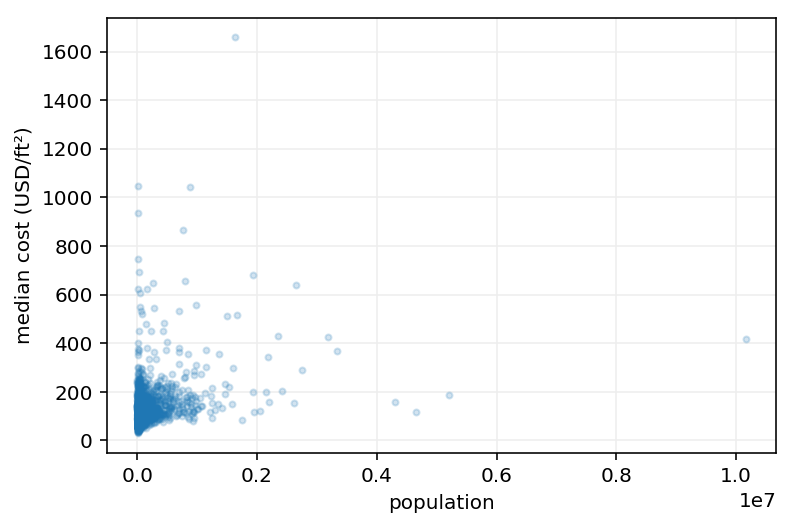

In [3]:
# Set up axes
fig, ax = plt.subplots()
ax.grid(color='#eeeeee')
ax.set_xlabel('population')
ax.set_ylabel('median cost (USD/ft²)')

ax.plot(df['population'], df['median_price_per_sqft'], '.', alpha=0.2);

<br />

### Scatter plot: median price per ft² vs. population (log scale)

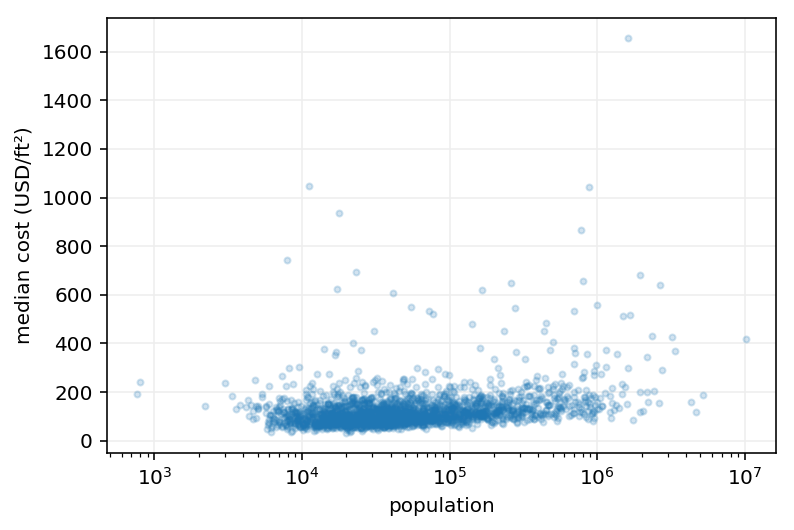

In [4]:
# Set up axes
fig, ax = plt.subplots()
ax.grid(color='#eeeeee')
ax.set_xlabel('population')
ax.set_ylabel('median cost (USD/ft²)')
ax.set_xscale('log')

ax.plot(df['population'], df['median_price_per_sqft'], '.', alpha=0.2);

<br />

### Scatter plot: median price per ft² (log scale) vs. population (log scale)

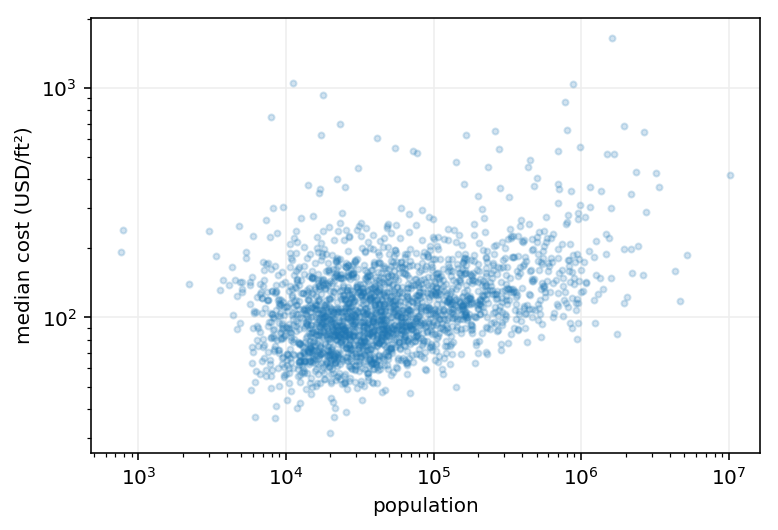

In [5]:
# Set up axes
fig, ax = plt.subplots()
ax.grid(color='#eeeeee')
ax.set_xlabel('population')
ax.set_ylabel('median cost (USD/ft²)')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(df['population'], df['median_price_per_sqft'], '.', alpha=0.2);

<br />

### Function to make x and y values for ECDF plots

In [6]:
def ecdf(data, formal=False, x_range=None):
    """
    Get x, y, values of an ECDF for plotting.

    Parameters
    ----------
    data : ndarray
        One dimensional Numpay array with data.
    formal : bool, default False
        If True, generate x and y values for formal ECDF (staircase). If
        False, generate x and y values for ECDF as dots.
    x_range : 2-tuple, default None
        If not None and `formal` is True, then specifies range of plot
        on x-axis.

    Returns
    -------
    x : ndarray
        x-values for plot
    y : ndarray
        y-values for plot
    """
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)

    if formal:
        # Set up output arrays
        x_formal = np.empty(2*(len(x) + 1))
        y_formal = np.empty(2*(len(x) + 1))

        # y-values for steps
        y_formal[:2] = 0
        y_formal[2::2] = y
        y_formal[3::2] = y

        # x- values for steps
        x_formal[0] = x[0]
        x_formal[1] = x[0]
        x_formal[2::2] = x
        x_formal[3:-1:2] = x[1:]
        x_formal[-1] = x[-1]
        
        if x_range is not None:
            if np.all(x >= x_range[0]) and np.all(x <= x_range[1]):
                x_formal = np.concatenate(((x_range[0],), x_formal, (x_range[1],)))
                y_formal = np.concatenate(((0,), y_formal, (1,)))
            else:
                raise RuntimeError('Some data values outside of `x_range`.')

        return x_formal, y_formal
    else:
        return x, y

<br />

### US metro area population ECDF

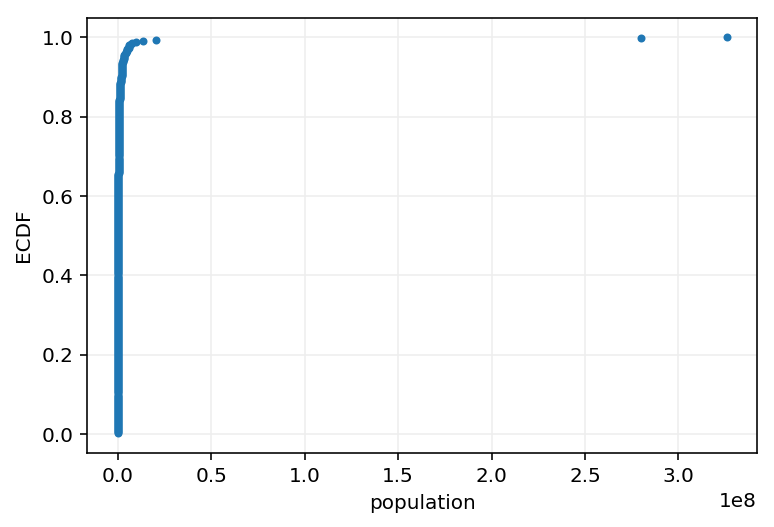

In [7]:
# Set up axes
fig, ax = plt.subplots()
ax.grid(color='#eeeeee')
ax.set_xlabel('population')
ax.set_ylabel('ECDF')
# ax.set_xscale('log')

ax.plot(*ecdf(df_metro['respop72017']), '.');

<br />

### US metro area population ECDF (log scale)

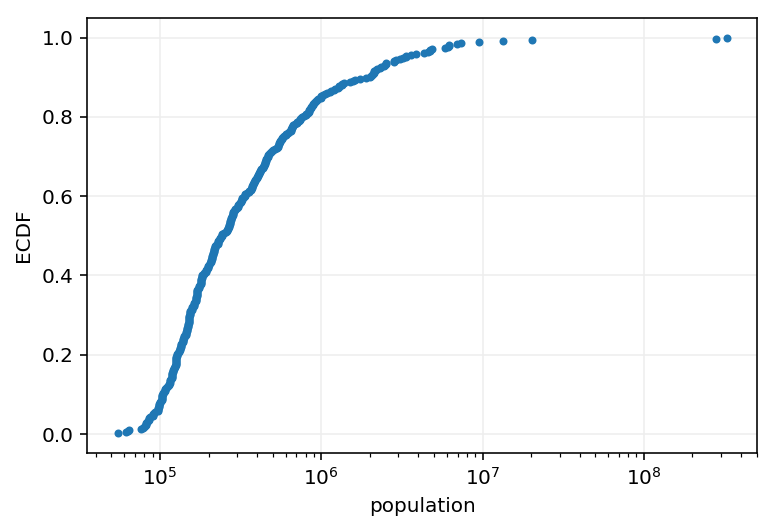

In [8]:
# Set up axes
fig, ax = plt.subplots()
ax.grid(color='#eeeeee')
ax.set_xlabel('population')
ax.set_ylabel('ECDF')
ax.set_xscale('log')

ax.plot(*ecdf(df_metro['respop72017']), '.');

<br />

### US metro area population ECCDF (log-log scale)

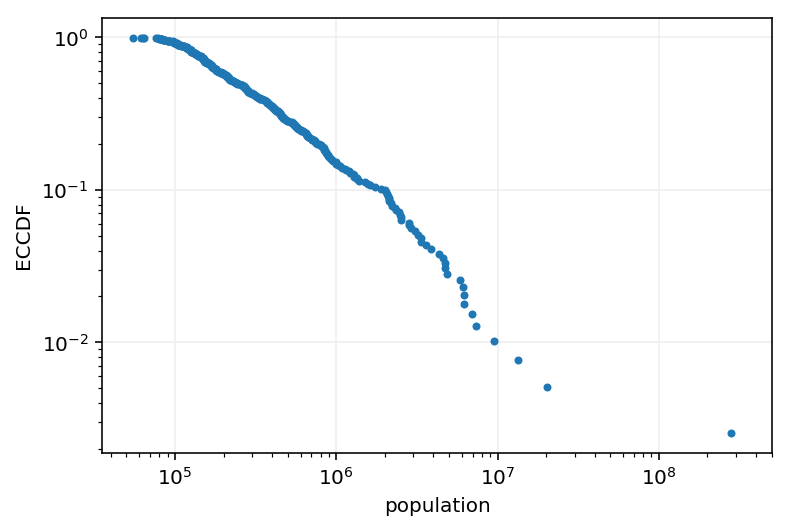

In [9]:
# Set up axes
fig, ax = plt.subplots()
ax.grid(color='#eeeeee')
ax.set_xlabel('population')
ax.set_ylabel('ECCDF')
ax.set_xscale('log')
ax.set_yscale('log')

x, y = ecdf(df_metro['respop72017'])
ax.plot(x, 1-y, '.');